In [ ]:
!pip install tqdm==4.66.1

In [ ]:
import keras.utils

import numpy as np
import pandas as pd
import re
import glob
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import keras
import warnings
import nltk
nltk.download('stopwords')
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/Google Drive/Important/papers.pkl")

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

def clean_body(text):
    newText = text.lower()
    newText = re.sub('[^\w\s\d\.]','',newText)
    newText = ' '.join(newText.split())
    tokens = [w for w in newText.split() if not w in STOP_WORDS]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)
    return (" ".join(long_words)).strip()

cleaned_body = []
for t in data['body']:
    cleaned_body.append(clean_body(t))

cleaned_body[:2]

['deterministic approaches simultaneously solve different interrelated optimisation problems lead general class nonlinear complementarity problem ncp. differentiability convexity requirements problems sophisticated algorithms introduced literature. paper develops evolutionary algorithm solve ncps. proposed approach parallel search multiple populations representing different agents evolve simultaneously whilst contact other. context agent autonomously solves optimisation programme sharing decisions neighbouring agents affects actions. framework applied environmental aerospace application obtained results compared found literature. convergence scalability approach tested search algorithm performance analysed. results encourage application evolutionary based algorithm complementarity problems future work investigate development performance improvements. study class problems solutions interrelated optimisation problems simultaneously required. context agent solves optimisation problem seek

In [ ]:
def clean_highlight(text):
  newText = text.lower()
  newText = re.sub('[^\w\s\d\.]','',newText)
  newText = ' '.join(newText.split())
  newText = '_START_ '+ newText + ' _END_'
  return newText


cleaned_highlight = []
for t in data['highlights']:
    cleaned_highlight.append(clean_highlight(t))

cleaned_highlight[:2]

['_START_ we develop an evolutionary approach to solve interrelated optimisation problems. multiple agents autonomously deal with their own problems and react to the others. test problems in water pollution and aerospace modelling demonstrate the algorithm. experiments on scalability and convergence of the algorithm show promising results. _END_',
 '_START_ the aggregated artificial neural network was used to investigate the simultaneous effects of printing parameters on the compressive strength and porosity of scaffolds. particle swarm optimization algorithm was implemented to obtain the optimum topology of the aann. pareto front optimization was used to determine the optimal setting parameters. the presented results and discussion can give informative information to practitioners who want to design a porous structure and need to know the impact of influential design parameters. _END_']

In [ ]:
data['cleaned_highlights'] = cleaned_highlight
data['cleaned_body'] = cleaned_body

In [ ]:
data = data[:5000]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 27 to 6950
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                5000 non-null   object
 1   filenames           5000 non-null   object
 2   highlights          5000 non-null   object
 3   body                5000 non-null   object
 4   cleaned_highlights  5000 non-null   object
 5   cleaned_body        5000 non-null   object
dtypes: object(6)
memory usage: 273.4+ KB


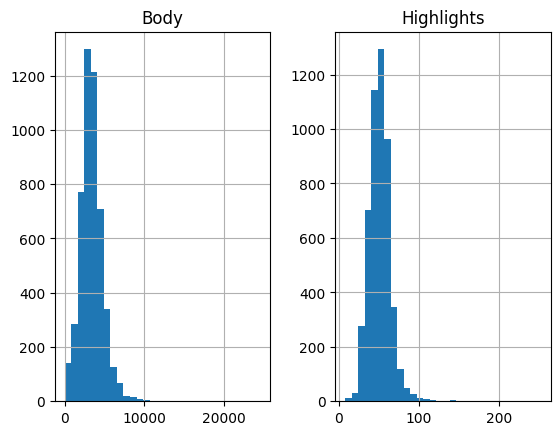

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_body']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Body':text_word_count, 'Highlights':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max_len_body = 1000
max_len_highlight = 50

In [ ]:
data.cleaned_body = data.cleaned_body.apply(lambda x: str(x))
data.cleaned_highlights = data.cleaned_highlights.apply(lambda x: str(x))

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data['cleaned_body'],data['cleaned_highlights'],test_size=0.2,random_state=0,shuffle=True)

In [ ]:
!pip install keras --upgrade

from keras.utils import pad_sequences
x_tok = Tokenizer()
x_tok.fit_on_texts(list(x_train))

# Converting text to number sequences
x_train = x_tok.texts_to_sequences(x_train)
x_test = x_tok.texts_to_sequences(x_test)

# Padding zero upto maximum length
x_train = pad_sequences(x_train,  maxlen=max_len_body, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len_body, padding='post')

# Total number of words
x_vocab_size = len(x_tok.word_index) +1

In [ ]:
# Tokenizing "highlights"
y_tok = Tokenizer()
y_tok.fit_on_texts(list(y_train))

# Converting text to number sequences
y_train = y_tok.texts_to_sequences(y_train)
y_test = y_tok.texts_to_sequences(y_test)

# Padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen=max_len_highlight, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_highlight, padding='post')

# Word count
y_vocab_size = len(y_tok.word_index) +1

In [ ]:
import tensorflow as tf

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, name='attention_layer', **kwargs):
        super(AttentionLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        encoder_outputs, decoder_outputs = inputs

        # Calculate the attention weights
        attention_weights = tf.matmul(
            decoder_outputs, encoder_outputs, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_weights, axis=-1)

        # Context vector
        context_vector = tf.matmul(attention_weights, encoder_outputs)

        return context_vector, attention_weights

latent_dim = 50

# Encoder
encoder_inputs = tf.keras.Input(shape=(max_len_body,))
enc_emb = tf.keras.layers.Embedding(x_vocab_size, latent_dim, trainable=True)(encoder_inputs)

# 1st LSTM Layer
encoder_lstm1 = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 2nd LSTM Layer
encoder_lstm2 = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 3rd LSTM Layer
encoder_lstm3 = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb_layer = tf.keras.layers.Embedding(y_vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
attn_layer = AttentionLayer()
context_vector, attn_weights = attn_layer([encoder_outputs, decoder_outputs])

# Concat context vector and decoder LSTM output
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, context_vector])

# Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Model Definition
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1000, 50)             1273040   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 1000, 50),           20200     ['embedding[0][0]']           
                              (None, 50),                                                         
                              (None, 50)]                                                     

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit([x_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:], epochs=30, callbacks=[es], batch_size=128,
                  validation_data=([x_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/30
32/32 [==============================] - 33s 597ms/step - loss: 9.2341 - val_loss: 7.8510
Epoch 2/30
32/32 [==============================] - 19s 591ms/step - loss: 7.2855 - val_loss: 6.6537
Epoch 3/30
32/32 [==============================] - 12s 374ms/step - loss: 6.8694 - val_loss: 6.5378
Epoch 4/30
32/32 [==============================] - 10s 311ms/step - loss: 6.7997 - val_loss: 6.4817
Epoch 5/30
32/32 [==============================] - 11s 350ms/step - loss: 6.7467 - val_loss: 6.4063
Epoch 6/30
32/32 [==============================] - 11s 330ms/step - loss: 6.6888 - val_loss: 6.3398
Epoch 7/30
32/32 [==============================] - 11s 351ms/step - loss: 6.6306 - val_loss: 6.2703
Epoch 8/30
32/32 [==============================] - 9s 300ms/step - loss: 6.5743 - val_loss: 6.2139
Epoch 9/30
32/32 [==============================] - 10s 318ms/step - loss: 6.5284 - val_loss: 6.1712
Epoch 10/30
32/32 [==============================] - 10s 326ms/step - loss: 6.4945 - val_los

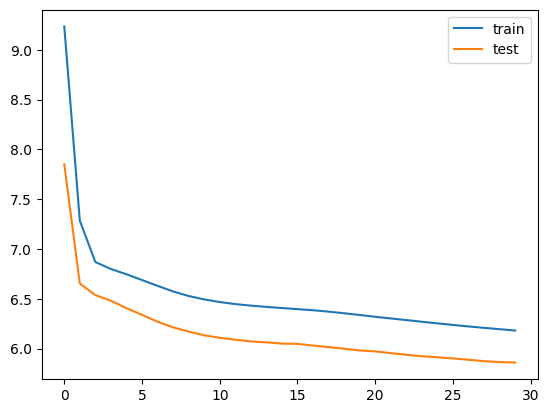

In [ ]:

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tok.index_word
reverse_source_word_index=x_tok.index_word
target_word_index=y_tok.word_index

In [ ]:
# Encoder Inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder Inference
# Below tensors hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_body,latent_dim))

# Getting decoder sequence embeddings
dec_emb2= dec_emb_layer(decoder_inputs)

# Predicting the next word in the sequence
# Setting the initial states to the previous time step states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention Inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense softmax layer to calculate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final Decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# Function to implement inference



def decode_sequence(input_seq):
    # Encoding input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    # Taking the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        try:
            sampled_token = reverse_target_word_index[sampled_token_index]
        except:
            sampled_token = reverse_target_word_index[np.random.randint(1, len(reverse_target_word_index))]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_highlight-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:

def seq2highlights(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString


In [ ]:

reference = []
hypothesis = []
for i in range(10):
  # Print the highlights
  print("Highlights:")
  print(seq2highlights(y_test[i]))

  # Add the highlights to the reference and hypothesis lists
  reference.append(seq2highlights(y_test[i]))
  hypothesis.append(decode_sequence(x_test[i].reshape(1,max_len_body)))

  # Print the predicted summary
  print("Predicted summary:")
  print(decode_sequence(x_test[i].reshape(1,max_len_body)))

  # Print a newline
  print("\n")

# Print the reference and hypothesis lists
print("Reference:")
print(reference)
print("\n")
print("Hypothesis:")
print(hypothesis)

Highlights:
reaction profiles of and transfer mechanisms were generated density functional theory methods were employed polar mechanism was investigated for the first time polar mechanism is not a favorable path transfer mechanism is more plausible than transfer 
1/1 [==============================] - 0s 21ms/step
Predicted summary:
1/1 [==============================] - 0s 22ms/step
 we the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


Highlights:
study dynamic portfolio selection with multiple risk measures in continuoustime help investors control both risk measure and downside risk measure solve analytically dynamic formulation solve analytically dynamic safetyfirst principle formulation reveal a curved property in optimal portfolio policies of our models 
1/1 [==============================] - 0s 23ms/step
Predicted summary:
1/1 [==========